In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

import os
from scipy.sparse import coo_matrix

In [22]:
train_data = pd.read_csv('walmart_data.tsv', sep='\t')

In [26]:
train_data.columns

Index(['Uniq Id', 'Crawl Timestamp', 'Dataset Origin', 'Product Id',
       'Product Barcode', 'Product Company Type Source',
       'Product Brand Source', 'Product Brand Normalised Source',
       'Product Name Source', 'Match Rank', 'Match Score', 'Match Type',
       'Retailer', 'Product Category', 'Product Brand', 'Product Name',
       'Product Price', 'Sku', 'Upc', 'Product Url', 'Market',
       'Product Description', 'Product Currency',
       'Product Available Inventory', 'Product Image Url',
       'Product Model Number', 'Product Tags', 'Product Contents',
       'Product Rating', 'Product Reviews Count', 'Bsr', 'Joining Key'],
      dtype='object')

In [25]:
train_data.head(2)

,Uniq Id,Crawl Timestamp,Dataset Origin,Product Id,Product Barcode,Product Company Type Source,Product Brand Source,Product Brand Normalised Source,Product Name Source,Match Rank,...,Product Currency,Product Available Inventory,Product Image Url,Product Model Number,Product Tags,Product Contents,Product Rating,Product Reviews Count,Bsr,Joining Key
0,1705736792d82aa2f2d3caf1c07c53f4,2020-09-24 03:21:12 +0000,NaN,2e17bf4acecdece67fc00f07ad62c910,NaN,Competitor,NaN,NaN,NaN,NaN,...,USD,111111111,https://i5.walmartimages.com/asr/0e1f4c51-c1a4...,NaN,"OPI Infinite Shine, Nail Lacquer Nail Polish, ...",NaN,NaN,NaN,NaN,81350af1be98d3753cf964709f0c766a
1,95a9fe6f4810fcfc7ff244fd06784f11,2020-10-30 14:04:08 +0000,NaN,076e5854a62dd283c253d6bae415af1f,NaN,Competitor,NaN,NaN,NaN,NaN,...,USD,111111111,https://i5.walmartimages.com/asr/9c8e42e4-13a5...,NaN,"Nice 'n Easy Permanent Color, 111 Natural Medi...",NaN,NaN,NaN,NaN,0353e63907dc0de0c734db4690300057


In [28]:
train_data = train_data[['Uniq Id', 'Product Id', 'Product Rating', 'Product Reviews Count', 'Product Category','Product Brand','Product Name','Product Image Url','Product Description' ]]

In [29]:
train_data.shape

(5000, 9)

In [30]:
train_data.isnull().sum()

Uniq Id                     0
Product Id                  0
Product Rating           2806
Product Reviews Count    1654
Product Category           10
Product Brand              13
Product Name                0
Product Image Url           0
Product Description      1127
dtype: int64

In [31]:
train_data.dtypes

Uniq Id                   object
Product Id                object
Product Rating           float64
Product Reviews Count    float64
Product Category          object
Product Brand             object
Product Name              object
Product Image Url         object
Product Description       object
dtype: object

In [34]:
# inplace make changes directly to the original DataFrame
train_data['Product Rating'].fillna(0, inplace=True)
train_data['Product Reviews Count'].fillna(0, inplace=True)
train_data['Product Category'].fillna('', inplace=True)
train_data['Product Brand'].fillna('', inplace=True)
train_data['Product Description'].fillna('', inplace=True)

C:\Users\ADESH\AppData\Local\Temp\ipykernel_3412\1842097386.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data['Product Rating'].fillna(0, inplace=True)
C:\Users\ADESH\AppData\Local\Temp\ipykernel_3412\1842097386.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['Product Rating'].fillna(0, inplace=True)
C:\Users\ADESH\

In [35]:
train_data.isnull().sum()

Uniq Id                  0
Product Id               0
Product Rating           0
Product Reviews Count    0
Product Category         0
Product Brand            0
Product Name             0
Product Image Url        0
Product Description      0
dtype: int64

In [36]:
column_name_mapping = {
    'Uniq Id': 'ID',
    'Product Id': 'ProdID',
    'Product Rating': 'Rating',
    'Product Reviews Count': 'ReviewCount',
    'Product Category': 'Category',
    'Product Brand': 'Brand',
    'Product Name': 'Name',
    'Product Image Url': 'ImageURL',
    'Product Description': 'Description',
    'Product Tags': 'Tags',
    'Product Contents': 'Contents'
}
train_data.rename(columns=column_name_mapping, inplace=True)

C:\Users\ADESH\AppData\Local\Temp\ipykernel_3412\1695967233.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.rename(columns=column_name_mapping, inplace=True)


In [37]:
train_data.head(2)

,ID,ProdID,Rating,ReviewCount,Category,Brand,Name,ImageURL,Description
0,1705736792d82aa2f2d3caf1c07c53f4,2e17bf4acecdece67fc00f07ad62c910,0.0,0.0,Premium Beauty > Premium Makeup > Premium Nail...,OPI,"OPI Infinite Shine, Nail Lacquer Nail Polish, ...",https://i5.walmartimages.com/asr/0e1f4c51-c1a4...,
1,95a9fe6f4810fcfc7ff244fd06784f11,076e5854a62dd283c253d6bae415af1f,0.0,0.0,Beauty > Hair Care > Hair Color > Auburn Hair ...,Nice'n Easy,"Nice n Easy Permanent Color, 111 Natural Mediu...",https://i5.walmartimages.com/asr/9c8e42e4-13a5...,Pack of 3 Pack of 3 for the UPC: 381519000201 ...


In [46]:
# for the cosinesimilarity we require the columns values of id and prod id in 
# in the float but it is in the string-int format so we change it with regular express
train_data['ID'] = train_data['ID'].str.extract(r'(\d+)').astype(float)
train_data['ProdID'] = train_data['ProdID'].str.extract(r'(\d+)').astype(float)


C:\Users\ADESH\AppData\Local\Temp\ipykernel_3412\1993387696.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['ID'] = train_data['ID'].str.extract(r'(\d+)').astype(float)
C:\Users\ADESH\AppData\Local\Temp\ipykernel_3412\1993387696.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['ProdID'] = train_data['ProdID'].str.extract(r'(\d+)').astype(float)


In [47]:
train_data.head(2)

,ID,ProdID,Rating,ReviewCount,Category,Brand,Name,ImageURL,Description
0,1.705737e+09,2.0,0.0,0.0,Premium Beauty > Premium Makeup > Premium Nail...,OPI,"OPI Infinite Shine, Nail Lacquer Nail Polish, ...",https://i5.walmartimages.com/asr/0e1f4c51-c1a4...,
1,9.500000e+01,76.0,0.0,0.0,Beauty > Hair Care > Hair Color > Auburn Hair ...,Nice'n Easy,"Nice n Easy Permanent Color, 111 Natural Mediu...",https://i5.walmartimages.com/asr/9c8e42e4-13a5...,Pack of 3 Pack of 3 for the UPC: 381519000201 ...


### EDA

In [48]:
train_data.columns

Index(['ID', 'ProdID', 'Rating', 'ReviewCount', 'Category', 'Brand', 'Name',
       'ImageURL', 'Description'],
      dtype='object')

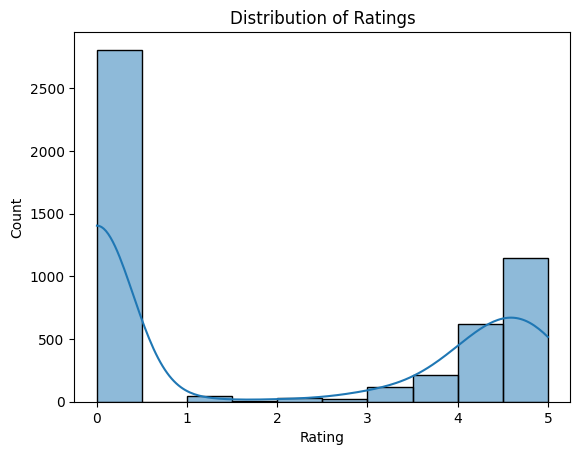

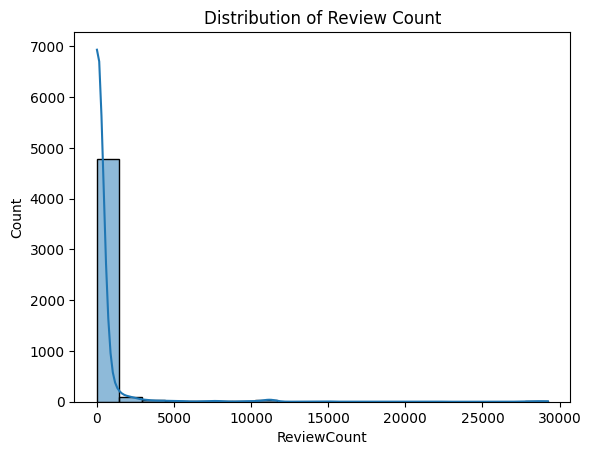

In [53]:
sns.histplot(train_data['Rating'].dropna(), bins=10, kde=True)
plt.title('Distribution of Ratings')
plt.show()

sns.histplot(train_data['ReviewCount'].dropna(), bins=20, kde=True)
plt.title('Distribution of Review Count')
plt.show()

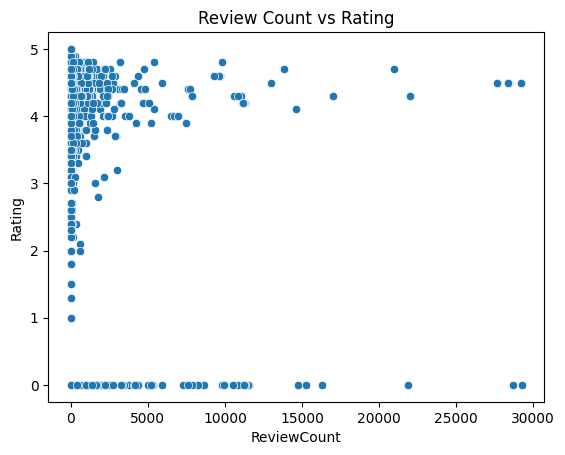

In [ ]:
# here dot representing the products
sns.scatterplot(x='ReviewCount', y='Rating', data=train_data)
plt.title('Review Count vs Rating')
plt.show()

In [61]:
# we have to generate the tags for the products
# for that we will concatenate the category, brand, and decription 
# let's first clean these columns
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
nlp = spacy.load('en_core_web_sm')
def clean_and_extract_tags(text):
    doc = nlp(text.lower())
    tags = [token.text for token in doc if token.text.isalnum() and token.text not in STOP_WORDS]
    return ', '.join(tags)
columns_to_clean = ['Category', 'Brand', 'Description']
for c in columns_to_clean:
    train_data[c] = train_data[c].apply(clean_and_extract_tags)


C:\Users\ADESH\AppData\Local\Temp\ipykernel_3412\2873331160.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data[c] = train_data[c].apply(clean_and_extract_tags)


In [63]:
# Concatenate the cleaned tags from all relevant columns
train_data['Tags'] = train_data[columns_to_clean].apply(lambda row: ', '.join(row), axis=1)

C:\Users\ADESH\AppData\Local\Temp\ipykernel_3412\93393723.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['Tags'] = train_data[columns_to_clean].apply(lambda row: ', '.join(row), axis=1)


In [64]:
train_data.head(2)

,ID,ProdID,Rating,ReviewCount,Category,Brand,Name,ImageURL,Description,Tags
0,1.705737e+09,2.0,0.0,0.0,"premium, beauty, premium, makeup, premium, nai...",opi,"OPI Infinite Shine, Nail Lacquer Nail Polish, ...",https://i5.walmartimages.com/asr/0e1f4c51-c1a4...,,"premium, beauty, premium, makeup, premium, nai..."
1,9.500000e+01,76.0,0.0,0.0,"beauty, hair, care, hair, color, auburn, hair,...",easy,"Nice n Easy Permanent Color, 111 Natural Mediu...",https://i5.walmartimages.com/asr/9c8e42e4-13a5...,"pack, 3, pack, 3, upc, 381519000201, beautiful...","beauty, hair, care, hair, color, auburn, hair,..."


### Rating Based Recommemdation

In [67]:
avg_rating = train_data.groupby(['Name', 'ReviewCount', 'Brand', 'ImageURL'])['Rating'].mean().reset_index()

In [69]:
top_rated_items = avg_rating.sort_values(by='Rating', ascending=False).head(10)

In [70]:
top_rated_items

,Name,ReviewCount,Brand,ImageURL,Rating
1686,"Electric Shaver, Triple Shaving Time Electric ...",4.0,moosoo,https://i5.walmartimages.com/asr/e7dcd553-90df...,5.0
526,"Alaffia Body Lotion, Vanilla, 32 Oz",2.0,alaffia,https://i5.walmartimages.com/asr/2988c323-cb6f...,5.0
2053,"Gold Bond Ultimate Ultimate Healing Lotion, Al...",2.0,"gold, bond",https://i5.walmartimages.com/asr/34b610e7-05db...,5.0
4716,"Versace Man Eau Fraiche Eau De Toilette Spray,...",24.0,versace,https://i5.walmartimages.com/asr/edaaeed5-9da0...,5.0
2058,Goldwell StyleSign 1 Flat Marvel Straightening...,2.0,goldwell,https://i5.walmartimages.com/asr/3bf90289-6980...,5.0
3842,"Red Devil 0322 Steel Wool # 00 Very Fine, 8 Pa...",1.0,"red, devil",https://i5.walmartimages.com/asr/60bfe5ba-774c...,5.0
510,"Air Wick Plug in Starter Kit, Warmer + 1 Refil...",1.0,"air, wick",https://i5.walmartimages.com/asr/0fac65b2-c6aa...,5.0
3841,Recovery Complex Anti-Frizz Shine Serum by Bai...,4.0,"bain, de, terre",https://i5.walmartimages.com/asr/fcdb4d2e-3727...,5.0
2687,Long Aid Extra Dry Formula Curl Activator Gel ...,12.0,"long, aid",https://i5.walmartimages.com/asr/f7f29199-bfa5...,5.0
2062,"Good Sense 60-Day Air Care System, Citrus, 2 o...",1.0,diversey,https://i5.walmartimages.com/asr/025a7068-7bb1...,5.0


In [71]:
# changing the datatype of rating and review count to int
top_rated_items['Rating'] = top_rated_items['Rating'].astype(int)
top_rated_items['ReviewCount'] = top_rated_items['ReviewCount'].astype(int)

### Content Based recommendation System

In [75]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
# here each row is the doc and columns are the features
tfidf_matrix_content = tfidf_vectorizer.fit_transform(train_data['Tags']) #forms the tfidf matrix
cosine_similarity_content = cosine_similarity(tfidf_matrix_content, tfidf_matrix_content)


In [76]:
cosine_similarity_content

array([[1.        , 0.00347577, 0.00363226, ..., 0.13535785, 0.31726435,
        0.05689108],
       [0.00347577, 1.        , 0.38086046, ..., 0.02315363, 0.00183907,
        0.0381051 ],
       [0.00363226, 0.38086046, 1.        , ..., 0.03960089, 0.00192187,
        0.0591094 ],
       ...,
       [0.13535785, 0.02315363, 0.03960089, ..., 1.        , 0.00123005,
        0.0379399 ],
       [0.31726435, 0.00183907, 0.00192187, ..., 0.00123005, 1.        ,
        0.00544407],
       [0.05689108, 0.0381051 , 0.0591094 , ..., 0.0379399 , 0.00544407,
        1.        ]])

In [82]:
train_data['Name'][0]

'OPI Infinite Shine, Nail Lacquer Nail Polish, Bubble Bath'

In [88]:
item_name = 'OPI Infinite Shine, Nail Lacquer Nail Polish, Bubble Bath'
item_index = train_data[train_data['Name'] == item_name].index[0]

In [90]:
item_index

0

In [101]:
similar_item = list(enumerate(cosine_similarity_content[item_index]))

In [102]:
similar_item

[(0, 1.0),
 (1, 0.0034757732312750934),
 (2, 0.003632261383918426),
 (3, 0.013151377769582695),
 (4, 0.0010160210269512565),
 (5, 0.006575809352364544),
 (6, 0.007328463323503305),
 (7, 0.05151153351231972),
 (8, 0.011109860476686882),
 (9, 0.003151730172379002),
 (10, 0.0),
 (11, 0.1587457628497677),
 (12, 0.04098008361044332),
 (13, 0.0030468898686792107),
 (14, 0.0),
 (15, 0.0059693458494800575),
 (16, 0.3398806576145607),
 (17, 0.0),
 (18, 0.004556103655641239),
 (19, 0.0038887588090144405),
 (20, 0.008764149884645193),
 (21, 0.0),
 (22, 0.009458897953602717),
 (23, 0.0),
 (24, 0.00517558550504985),
 (25, 0.0),
 (26, 0.007172857177991527),
 (27, 0.003259884833851906),
 (28, 0.2812052802661157),
 (29, 0.0),
 (30, 0.007207084216281134),
 (31, 0.006229511383962109),
 (32, 0.008773214115073319),
 (33, 0.010764957375515107),
 (34, 0.005638510010303099),
 (35, 0.01026020396150954),
 (36, 0.0020164119152476824),
 (37, 0.0032782013683666338),
 (38, 0.005164021192923341),
 (39, 0.0),
 (40, 

In [103]:
similar_items = sorted(similar_item, key=lambda x: x[1], reverse=True) 

In [107]:
train_data.duplicated().sum()

1

In [ ]:
top_items = similar_items[1:10]
recommendated_items = [x[0] for x in top_items]


[156, 184, 205, 237, 325, 375, 402, 706, 886]

In [114]:
train_data.iloc[recommendated_items][['Name', 'ReviewCount', 'Brand']]

,Name,ReviewCount,Brand
156,OPI Nail Lacquer Polish .5oz/15mL - This Gown ...,0.0,opi
184,OPI Nail Gel Polish GelColor .5oz/15mL 3 CT Co...,0.0,opi
205,OPI Nail Lacquer - Dont Bossa Nova Me Around -...,0.0,opi
237,OPI Infinite Shine 2 Polish - ISL P33 - Alpaca...,5.0,opi
325,OPI Gel Polish Fall 2019 Scotland Collection G...,1.0,opi
375,OPI Nail Gel Polish GelColor .5oz/15mL 3 CT Co...,1.0,opi
402,"OPI Nail Polish, Strawberry Margarita, 0.5 Fl Oz",57.0,opi
706,OPI Nail Gel Polish GelColor .5oz/15mL 3 CT Co...,1.0,opi
886,OPI- Nail Lacquer-GelColor - &quotLiv&quotin t...,0.0,opi


In [115]:
def content_based_recommendations(train_data, item_name, top_n=10):
    # Check if the item name exists in the training data
    if item_name not in train_data['Name'].values:
        print(f"Item '{item_name}' not found in the training data.")
        return pd.DataFrame()

    # Create a TF-IDF vectorizer for item descriptions
    tfidf_vectorizer = TfidfVectorizer(stop_words='english')

    # Apply TF-IDF vectorization to item descriptions
    tfidf_matrix_content = tfidf_vectorizer.fit_transform(train_data['Tags'])

    # Calculate cosine similarity between items based on descriptions
    cosine_similarities_content = cosine_similarity(tfidf_matrix_content, tfidf_matrix_content)

    # Find the index of the item
    item_index = train_data[train_data['Name'] == item_name].index[0]

    # Get the cosine similarity scores for the item
    similar_items = list(enumerate(cosine_similarities_content[item_index]))

    # Sort similar items by similarity score in descending order
    similar_items = sorted(similar_items, key=lambda x: x[1], reverse=True)

    # Get the top N most similar items (excluding the item itself)
    top_similar_items = similar_items[1:top_n+1]

    # Get the indices of the top similar items
    recommended_item_indices = [x[0] for x in top_similar_items]

    # Get the details of the top similar items
    recommended_items_details = train_data.iloc[recommended_item_indices][['Name', 'ReviewCount', 'Brand', 'ImageURL', 'Rating']]

    return recommended_items_details

In [118]:
train_data['Name'][7]

'BMC Bright and Loud Cream Gel Lacquer Polish Set - Neon Wasteland Collection'

In [119]:
item_name = 'BMC Bright and Loud Cream Gel Lacquer Polish Set - Neon Wasteland Collection'
content_based_rec = content_based_recommendations(train_data, item_name, top_n=8)

content_based_rec

,Name,ReviewCount,Brand,ImageURL,Rating
3120,"Sensationail Express Gel Nail Polish (White), ...",23.0,sensationail,https://i5.walmartimages.com/asr/a6ebc6b8-0fc9...,0.0
775,"Sally Hansen Miracle Gel Nail Polish, Leaf Me ...",11272.0,"sally, hansen",https://i5.walmartimages.com/asr/13c7e57c-526b...,4.2
1461,Just Gel BLUE HAVEN,0.0,ibd,https://i5.walmartimages.com/asr/aa40f091-849d...,0.0
2942,"Sally Hansen Miracle Gel Nail Polish, Smarteas...",11266.0,"sally, hansen",https://i5.walmartimages.com/asr/dcac19a4-d67e...,4.2
3642,"Sally Hansen Miracle Gel Nail Polish, Cant Bee...",11334.0,"sally, hansen",https://i5.walmartimages.com/asr/25bc09e7-ff0d...,0.0
3297,"Sally Hansen Miracle Gel Nail Polish, Lets Get...",11194.0,"sally, hansen",https://i5.walmartimages.com/asr/a157062c-8bb4...,4.2
4462,"Sally Hansen Miracle Gel Nail Polish, Birthday...",11224.0,"sally, hansen",https://i5.walmartimages.com/asr/3cd65509-149c...,4.2
683,"Sally Hansen Miracle Gel Nail Polish, Slate - ...",11540.0,"sally, hansen",https://i5.walmartimages.com/asr/4368da4e-f8bb...,0.0


In [120]:
train_data.head(5)

,ID,ProdID,Rating,ReviewCount,Category,Brand,Name,ImageURL,Description,Tags
0,1.705737e+09,2.0,0.0,0.0,"premium, beauty, premium, makeup, premium, nai...",opi,"OPI Infinite Shine, Nail Lacquer Nail Polish, ...",https://i5.walmartimages.com/asr/0e1f4c51-c1a4...,,"premium, beauty, premium, makeup, premium, nai..."
1,9.500000e+01,76.0,0.0,0.0,"beauty, hair, care, hair, color, auburn, hair,...",easy,"Nice n Easy Permanent Color, 111 Natural Mediu...",https://i5.walmartimages.com/asr/9c8e42e4-13a5...,"pack, 3, pack, 3, upc, 381519000201, beautiful...","beauty, hair, care, hair, color, auburn, hair,..."
2,8.000000e+00,8.0,4.5,29221.0,"beauty, hair, care, hair, color, permanent, ha...",clairol,Clairol Nice N Easy Permanent Color 7/106A Nat...,https://i5.walmartimages.com/asr/e3a601c2-6a2b...,"clairol, nice, n, easy, permanent, color, give...","beauty, hair, care, hair, color, permanent, ha..."
3,4.000000e+00,3.0,0.0,0.0,"beauty, makeup, lip","kokie, cosmetics","Kokie Professional Matte Lipstick, Hot Berry, ...",https://i5.walmartimages.com/asr/25b4b467-bc61...,"calling, matte, lip, lovers, indulge, rich, cr...","beauty, makeup, lip, kokie, cosmetics, calling..."
4,9.900000e+02,3.0,0.0,131.0,"seasonal, stock, essentials, personal, care, s...",gillette,"Gillette TRAC II Plus Razor Blade Refills, Fit...",https://i5.walmartimages.com/asr/1a2ebb06-cd01...,"1971, gillette, introduced, trac, ii, razor, s...","seasonal, stock, essentials, personal, care, s..."
